In [ ]:
!pip install folium
!pip install rtree

In [ ]:
!pip3 uninstall rtree
!sudo apt install libspatialindex-dev
!pip3 install rtree

In [1008]:
import geopandas as gpd

year = 1917
paper = 'neue_freie_presse'

geometry = gpd.read_file(f'locations/{year}/{paper}.geojson')

geometry

mention  \
0                                                   Wien   
1                                                 Berlin   
2                                            Deutschland   
3                                            Oesterreich   
4                                                 Ungarn   
...                                                  ...   
26797  Bankoberbeamter i . P . , Währtngerstraße 18 ,...   
26798                                           Hellmann   
26799                                     Pension Herald   
26800                                        Franzöfisch   
26801                                        35 , Tür 32   

                                                 address     freq  \
0                                       Wien, Österreich  37255.0   
1                             Berlin, 10117, Deutschland   6814.0   
2                                            Deutschland   6228.0   
3                                             Österreich   6182.0   
4                                           Magyarország   5976.0   
...                                                  ...      ...   
26797                                               None      2.0   
26798  Hellmann, Greven, Kreis Steinfurt, Nordrhein-W...      2.0   
26799  The Hollies, Low Road, Auchtermuchty, Fife, Sc...      2.0   
26800                                               None      2.0   
26801  32, Porte de l'Université, Les Deux Lions, Tou...      2.0   

                        geometry  
0      POINT (16.37250 48.20835)  
1      POINT (13.38886 52.51704)  
2      POINT (10.42345 51.08342)  
3      POINT (13.20000 47.20000)  
4      POINT (19.50609 47.18176)  
...                          ...  
26797                       None  
26798   POINT (7.65141 52.08072)  
26799  POINT (-3.23064 56.29066)  
26800                       None  
26801   POINT (0.68018 47.36643)  

[26802 rows x 4 columns]

In [763]:
import geopandas as gpd
# import rtree
# gpd.options.use_pygeos = False

shape_1914 = gpd.read_file('shapefiles/cntry1914.shp')
shape_1914.set_index('NAME', inplace=True)

/home/vagrant/.local/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/home/vagrant/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


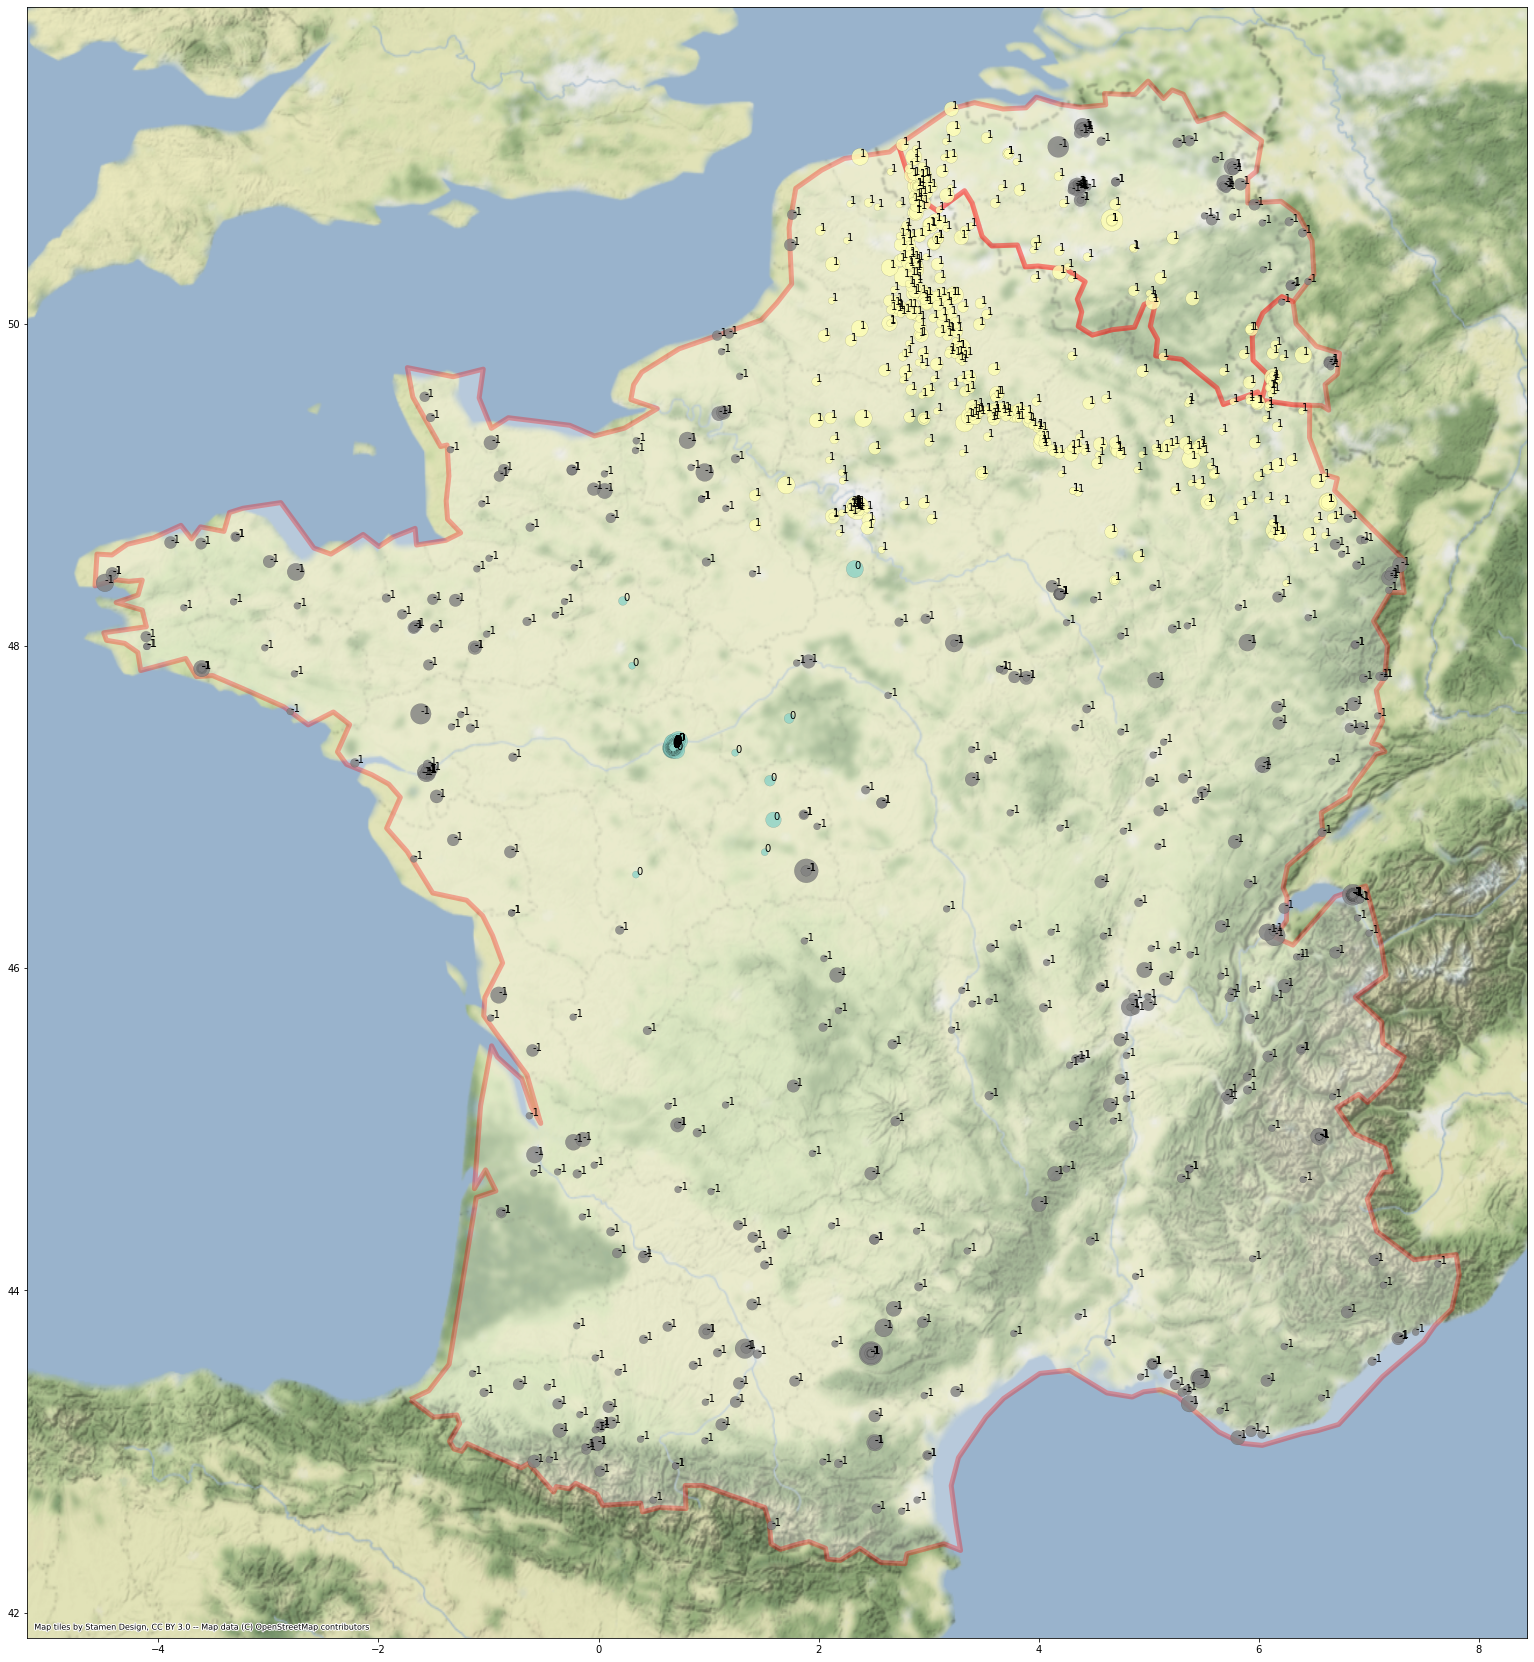

In [1009]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx

import hdbscan
import pandas as pd

from shapely.ops import cascaded_union

from sklearn.cluster import OPTICS
from shapely.geometry import Polygon

import rtree

def plot_events(countries, levels=10, th=.3, min_freq=1, clustering=0, remove_outliers=0, kde=0, draw_map=0, add_pn_annot=0, debug=0):
    palette = sns.color_palette('Set3')
    
    fig, ax = plt.subplots(figsize=(30,30))
    # ax.set_xlim(15, 50)
    
    shape_1914.set_crs(epsg=4326, inplace=True)
    
    global geometry
    
    geometry.set_crs(epsg=4326, inplace=True)
    
    shape_1914.loc[countries].plot(ax=ax, color='white', alpha=.3, edgecolor='red', linewidth=5)
    inpoly = geometry.within(cascaded_union(shape_1914.loc[countries].geometry))
    goodpoints = geometry[inpoly]
    result = geometry[inpoly]
    
    if draw_map:
        cx.add_basemap(ax=ax, crs=shape_1914.crs.to_string(), source=cx.providers.Stamen.TerrainBackground)  # cx.providers.OpenTopoMap, cx.providers.Stamen.TerrainBackground
    
    vectors = get_coords(goodpoints)
    colors = palette[3]
    
    if clustering:
        # clusterer = KMeans(n_clusters=6)
        # clusterer = DBSCAN(eps=.275, min_samples=20, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=-1)
        # clusterer = OPTICS(min_samples=5, max_eps=5, metric='minkowski', p=2, metric_params=None, cluster_method='xi', eps=None, xi=0.5,
        #                   predecessor_correction=True, min_cluster_size=None, algorithm='auto', leaf_size=30, n_jobs=-1)
        
        clusterer = hdbscan.HDBSCAN(min_cluster_size=70, metric='euclidean',
                                    cluster_selection_epsilon=.5,
                                    gen_min_span_tree=False)
        
        clusterer.fit(vectors)
        result.loc[:, 'cluster'] = clusterer.labels_
    
        colors = [palette[col % len(palette)] if col >= 0 else (0.5, 0.5, 0.5) for col in clusterer.labels_]
        
        if debug:
            for p in vectors.itertuples():
                ax.annotate(clusterer.labels_[p.Index], (p.x, p.y))
    
    goodpoints = goodpoints[goodpoints.freq > min_freq]
    
    if add_pn_annot:
        for p in goodpoints[goodpoints.freq > 50].itertuples():
            ax.annotate(p.mention, (p.geometry.x, p.geometry.y))
    
    log_freqs = np.log2(goodpoints.freq)   # np.log2(goodpoints.freq)*10
    log_freqs *= 50
    
    goodpoints.plot(ax=ax, color=colors, markersize=log_freqs, alpha=.8, edgecolor='black', linewidth=.1)
    
    # sns.histplot(data=vectors, x='x', y='y', ax=ax, fill=True, bins=7)
    
    if kde:
        sns.kdeplot(data=vectors, x='x', y='y',
                    levels=levels, thresh=th, weights=log_freqs,
                    color=palette[2], fill=True, cmap="mako", alpha=.6, ax=ax)
            
    return result


labels = plot_events(countries=['France', 'Belgium', 'Luxembourg'],# 'German Empire', 'Austro-Hungarian Empire'],
                     levels=10, th=.1, min_freq=1, clustering=1, kde=0, draw_map=1, add_pn_annot=0, debug=1)

In [1011]:
' | '.join(labels[labels.cluster == 1].mention.tolist())

"Paris | Belgien | St . Quentin | Arras | Lens | Deutsche Reich | Verdun | Ypern | Soissons | Reims | 7231 | Cambrai | Braunstein | Oise | Bullecourt | reich | Craonne | Lothringen | Aisne | 6565 | Dünkirchen | Scarpe | Braye | Somme | Dixmude | Vauxaillon | Langemarck | Loos | Hollebeke | Avocourt | Armentières | La Bassée | St . Mihiel | Gavrelle | Ancre | 10396 | Poelkapelle | Laffaux | Nordfrankreich | 111 , Rue Réaumur | Hulluch | Prosnes | Bezonvaux | Metz | Bourlon | Lille | Brügge | Warneton | Menin | Laon | Bapaume | Monchy | Versailles | Fresnoy | La Fere | 5572 | Peiersburg | Mosel | Peronne | Steenstraete | 4335 | Parie | Zeebrügge | 6567 | Oppy | Ailles | Moronvilliers | 7245 | Ripont | Tahure | 59120 | Wytschaete | Queant | Samogneux | Sapigneul | Belgiens | Reich | Corbeny | Hargicourt | 111 , Rue Fr | St . Leger | Poincaré | Neuville | Serres | 94012 | Aisne = Marne = Kanal | Saint = Quentin | Vauclerc | Roye | Noyon | Croisilles | Don | Nancy | Seine | Avion | Banteux 

In [1012]:
import pandas as pd

ents = pd.read_json('entities/1917/neue_freie_presse.json')

place_enriched_ents = ents.merge(geometry)

place_enriched_ents

id  \
0          entity_mention_neue_freie_presse_nfp19170102_1   
1          entity_mention_neue_freie_presse_nfp19170102_3   
2         entity_mention_neue_freie_presse_nfp19170102_19   
3         entity_mention_neue_freie_presse_nfp19170102_20   
4         entity_mention_neue_freie_presse_nfp19170102_47   
...                                                   ...   
395472  entity_mention_neue_freie_presse_nfp19171230_4229   
395473   entity_mention_neue_freie_presse_nfp19171231_326   
395474   entity_mention_neue_freie_presse_nfp19171231_335   
395475   entity_mention_neue_freie_presse_nfp19171231_719   
395476   entity_mention_neue_freie_presse_nfp19171231_720   

                                        link type                 mention  \
0        https://www.wikidata.org/wiki/Q1741  LOC                    Wien   
1        https://www.wikidata.org/wiki/Q1741  LOC                    Wien   
2        https://www.wikidata.org/wiki/Q1741  LOC                    Wien   
3        https://www.wikidata.org/wiki/Q1741  LOC                    Wien   
4        https://www.wikidata.org/wiki/Q1741  LOC                    Wien   
...                                      ...  ...                     ...   
395472                                  None  LOC  B . , Lazarettgasse 13   
395473  https://www.wikidata.org/wiki/Q46593  LOC               Pederobba   
395474  https://www.wikidata.org/wiki/Q46593  LOC               Pederobba   
395475                                  None  LOC            Abfallfetten   
395476                                  None  LOC            Abfallfetten   

        start_idx  end_idx  stance       date  \
0              15       19       0 1917-01-02   
1               0        4       0 1917-01-02   
2               0        4       0 1917-01-02   
3              70       74       0 1917-01-02   
4               8       12       0 1917-01-02   
...           ...      ...     ...        ...   
395472        323      343       0 1917-12-30   
395473         73       82       0 1917-12-31   
395474          4       13       0 1917-12-31   
395475         17       29       0 1917-12-31   
395476        120      132       0 1917-12-31   

                                                  address     freq  \
0                                        Wien, Österreich  37255.0   
1                                        Wien, Österreich  37255.0   
2                                        Wien, Österreich  37255.0   
3                                        Wien, Österreich  37255.0   
4                                        Wien, Österreich  37255.0   
...                                                   ...      ...   
395472  13, Lazarettgasse, Michelbeuern, KG Alsergrund...      2.0   
395473                 Pederobba, Treviso, Veneto, Italia      2.0   
395474                 Pederobba, Treviso, Veneto, Italia      2.0   
395475                                               None      2.0   
395476                                               None      2.0   

                         geometry  
0       POINT (16.37250 48.20835)  
1       POINT (16.37250 48.20835)  
2       POINT (16.37250 48.20835)  
3       POINT (16.37250 48.20835)  
4       POINT (16.37250 48.20835)  
...                           ...  
395472  POINT (16.34968 48.21757)  
395473  POINT (11.96955 45.86952)  
395474  POINT (11.96955 45.86952)  
395475                       None  
395476                       None  

[395477 rows x 11 columns]

In [674]:
labels[labels.geometry.isna()]

Empty GeoDataFrame
Columns: [mention, address, freq, geometry, cluster]
Index: []

In [ ]:
from shapely.geometry import Point
from shapely import wkt

battles = pd.read_csv('Battles in WW1.csv')
battles.rename(columns = {'coordinates': 'geometry'}, inplace = True)

battles = gpd.GeoDataFrame(battles)
battles.crs = 'epsg:4326'

battles.geometry.apply(wkt.loads)
battles[battles.geometry.notna()] = battles[battles.geometry.notna()].apply(wkt.loads)

battles

In [ ]:
battles.to_file('WWI_battles.geojson', driver='GeoJSON')

In [547]:
import folium
from folium import plugins

vectors = np.radians([(p.x, p.y) for p in geometry.geometry if p])

m = folium.Map(location=vectors[0], zoom_start=5, tiles="Stamen Terrain")
folium.GeoJson('locations/1914/arbeiter_zeitung.geojson', name="geojson").add_to(m)

plugins.HeatMap(vectors).add_to(m)

m